# Water Table Analysis
Author: Ian Coleman <br>
Purpose: Analyse water table data

Plan of action:
- Read, re-read the project description
- Import Data
- Decide a data-type for each column
- Assign data type, solving each error as it arises until the assignation runs through
- Plot each column - look for common problems
- Visually assess dataframe for other systematic errors 
- Replace missing, corrupt or suspect data with null/column mean 
- Encode categorical and binary columns
- Normalise / standardise where appropriate
- Use human understanding of dataset to determine if any feature engineering needed - combining variables or exponent 
- Test each column pairing for correlation/distance
- From this identify dependent variable pairings
- Mitigate these dependencies
- Investigate relationship of each column against outcome variable
- From this select variables to put in model
- Determine model-comparison metric(s)
- Consider best models, implement top 2/3
- Compare model performance
- Re-read project description
- Brainstorm on further improvements
- Look back over everything, clean and thoroughly document every decision

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import subprocess
import math
import seaborn as sb
import pdb
from correlade import correlade # I published this library
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

### Import Data

In [2]:
wt = pd.read_csv("data.csv")

/home/ian/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Iterate through columns, choose the best data type for each
# NB the output will need to be checked by some common sense
# If memory were likely to be an issue, we could further use uints and small numeric dtypes like int8

cat_cols = []
int_cols = []
float_cols = []
bool_cols = []
undetermined = []

for col in wt.columns:
    clean_col = wt[col].replace(0, np.nan)
    clean_col = wt[col].replace(0.0, np.nan)
    clean_col = wt[col].dropna()
    mode_val = str(clean_col.mode().values[0]).lower()
    
    if mode_val == 'true' or mode_val == 'false':
        bool_cols.append(col)
    elif isinstance(clean_col.mode().values[0], float):
        float_cols.append(col)
    elif mode_val.isnumeric():
        int_cols.append(col)
    elif (len(clean_col.unique()) < 200):
        cat_cols.append(col)
    else:
        undetermined.append(col)
        
        
print("\n int_cols --  \n", int_cols)
print("\n float_cols --  \n", float_cols)
print("\n cat_cols --  \n", cat_cols)
print("\n bool_cols --  \n", bool_cols)
print("\n undetermined --  \n", undetermined)


 int_cols --  
 ['id', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

 float_cols --  
 ['amount_tsh', 'gps_height', 'longitude', 'latitude']

 cat_cols --  
 ['basin', 'region', 'lga', 'recorded_by', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

 bool_cols --  
 ['public_meeting', 'permit']

 undetermined --  
 ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name']


In [5]:
## Create a dictionary of the selected data types, in order to assign them to the columns

cat_cols = {key: "category" for key in cat_cols}
int_cols = {key: "int" for key in int_cols}
float_cols = {key: "float" for key in float_cols}
bool_cols = {key: "bool" for key in bool_cols} 
undetermined = {key: "object" for key in undetermined}
col_types = {**cat_cols, **int_cols, **float_cols, **bool_cols}

In [6]:
## Enter the required changes identified by common sense, to the auto-selected datatypes

col_types['date_recorded'] = 'datetime64'
col_types['region_code'] = 'category'
col_types['district_code'] = 'category'
# del col_types['date_recorded']

In [7]:
col_types

{'basin': 'category',
 'region': 'category',
 'lga': 'category',
 'recorded_by': 'category',
 'scheme_management': 'category',
 'extraction_type': 'category',
 'extraction_type_group': 'category',
 'extraction_type_class': 'category',
 'management': 'category',
 'management_group': 'category',
 'payment': 'category',
 'payment_type': 'category',
 'water_quality': 'category',
 'quality_group': 'category',
 'quantity': 'category',
 'quantity_group': 'category',
 'source': 'category',
 'source_type': 'category',
 'source_class': 'category',
 'waterpoint_type': 'category',
 'waterpoint_type_group': 'category',
 'id': 'int',
 'num_private': 'int',
 'region_code': 'category',
 'district_code': 'category',
 'population': 'int',
 'construction_year': 'int',
 'amount_tsh': 'float',
 'gps_height': 'float',
 'longitude': 'float',
 'latitude': 'float',
 'public_meeting': 'bool',
 'permit': 'bool',
 'date_recorded': 'datetime64'}

In [8]:
## Assign the data types, ignoring errors (for now)
for col in col_types:
    wt[col] = wt[col].astype(col_types[col], errors='ignore')

In [9]:
## In this cell I sweep through possible errors using astype conversion without ignoring errors, 
# I patch each error as it arises and rerun until it runs through. Handy way to catch edge cases of problematic data
# This won't catch everything e.g Typos -> should run value_counts() on all str/categoricals to test for this   

for col in float_cols:
    wt[col] = wt[col].apply(lambda x: x if isinstance(x, float) else np.nan)

for col in int_cols:
    wt[col] = wt[col].apply(lambda x: x if isinstance(x, int) else np.nan)
    wt[col] = wt[col].replace([np.inf, -np.inf], np.nan)
#     wt[col] = wt[col].replace(np.nan, 0) ->

for col in col_types:
    wt[col] = wt[col].astype(col_types[col])

In [10]:
# I visually glance through random rows for unpredicted systematic and random errors (run this cell * ~3)
wt.sample(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
8652,28200,0.0,2012-10-26,Kanisa,1418.0,Kanisa,34.317530,-1.376324,Kanisani,0,...,unknown,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
26066,40875,NaN,2011-07-23,World Vision,0.0,DWE,31.730072,-1.320593,Kakekele,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
16389,50565,NaN,2011-02-25,Private,94.0,DWE,38.864937,-6.768216,Kwa Ndende,1,...,per bucket,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1863,20476,0.0,2013-02-26,Rwssp,738.0,DWE,36.008043,-10.798690,Shuleni,0,...,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
16595,30314,NaN,2011-07-08,Tasaf,0.0,TASA,31.385992,-1.102533,Hospital,0,...,on failure,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
54147,350,0.0,2013-01-25,Fini Water,424.0,Fini Water,38.701886,-10.247249,Shuleni,1,...,never pay,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,other,other
15836,49464,0.0,2011-07-11,Tasaf,0.0,DWE,31.504455,-1.230908,Ofisini,0,...,never pay,coloured,colored,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
34069,33038,NaN,2013-01-25,Government Of Tanzania,492.0,Government,37.862091,-10.120179,Kwa Mzee Mpanganike,0,...,never pay,soft,good,dry,dry,river,river/lake,surface,communal standpipe multiple,communal standpipe
15533,60064,0.0,2013-02-28,Danida,1235.0,DANIDA,34.931345,-10.921792,Shuleni Sekondari,0,...,unknown,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe
1878,66694,6000.0,2013-08-03,Isf,532.0,ISF,38.050726,-4.260973,Kwa Regina,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe


In [11]:
wt.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                      float64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                          category
subvillage                       object
region                         category
region_code                    category
district_code                  category
lga                            category
ward                             object
population                        int64
public_meeting                     bool
recorded_by                    category
scheme_management              category
scheme_name                      object
permit                             bool
construction_year                 int64
extraction_type                category


In [12]:
# Import outcome csv
labels = pd.read_csv("labels.csv")
print('Shape: ', labels.shape)

Shape:  (59400, 2)


In [13]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [15]:
## Check id is unique
print(len(labels.id))
print(len(labels.id.unique()))
print(len(wt.id))
print(len(wt.id.unique()))

59400
59399
59401
59400


In [18]:
## Remove all duplicate id (every instance of a duplicated id to be safe)
labels['id'] = labels.id.drop_duplicates(keep=False)
wt['id'] = wt.id.drop_duplicates(keep=False)

59398

In [270]:
## assign types, iteratively accounting for errors in outcome csv

# This next line is aimed at a specific error - a bum value that I could likely match to a real value with time
labels['id'] = labels['id'].replace(to_replace ='[!]', value = np.nan, regex = True) 
labels['id'].dropna(inplace=True)
labels['id'] = labels['id'].astype(int)
labels['status_group'] = labels['status_group'].astype('category')

# Add the new col to the col-type object
cat_cols['status_group'] = 'category'

In [271]:
## Merge the two csvs

print("wt shape: ", wt.shape)
print("labels shape: ", labels.shape)

wt = wt.merge(labels, on='id', how='left')
print("wt shape post merge: ", wt.shape)

wt shape:  (59401, 40)
labels shape:  (59400, 2)
wt shape post merge:  (59402, 41)


In [272]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [273]:
## encode categoricals

for col in cat_cols:
    new_name = col + '_encoded'
    wt[new_name] = wt[col].cat.codes

In [274]:
## encode booleans

for col in bool_cols:
    new_name = col + '_encoded'
    wt[new_name] = wt[col].apply(lambda x: 0 if x is False else 1)
    wt[new_name] = wt[new_name].astype(np.int8)
    
# checking it worked
# wt[['public_meeting_encoded', 'permit_encoded', 'permit', 'public_meeting']]

### Exploratory Analysis

In [275]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,...,1,1,8,7,0,1,1,0,1,0
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,...,2,2,5,4,1,1,1,0,1,1
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,1,1,0,1,1,2,1,0,1,1
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,0,0,3,0,0,2,1,2,1,1
4,19728,0.0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0,...,3,3,5,4,1,1,1,0,1,1


In [276]:
wt.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_encoded,region_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
count,59402.000000,26634.000000,59401.000000,59402.000000,5.940200e+04,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,...,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000
mean,37115.198209,328.704545,668.299069,34.077513,-5.706111e+00,0.474125,179.902007,1300.675381,4.538366,9.835881,...,1.325747,1.325747,6.063230,4.758325,0.233746,2.574038,2.056177,0.841100,0.914902,0.705515
std,21453.555072,3284.004629,693.107111,6.567348,2.946057e+00,12.236024,471.476973,951.612717,2.896848,5.936992,...,0.803760,0.803760,2.034171,2.575695,0.434134,1.781431,1.378928,0.949874,0.279030,0.455815
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,-200.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,18519.250000,0.000000,0.000000,33.090410,-8.540946e+00,0.000000,0.000000,0.000000,2.000000,4.000000,...,1.000000,1.000000,5.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,25.000000,1986.000000,4.000000,10.000000,...,1.000000,1.000000,7.000000,6.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,55657.500000,20.000000,1319.000000,37.178460,-3.326168e+00,0.000000,214.750000,2004.000000,7.000000,15.000000,...,2.000000,2.000000,8.000000,7.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,30500.000000,2013.000000,9.000000,20.000000,...,4.000000,4.000000,9.000000,7.000000,2.000000,6.000000,5.000000,3.000000,1.000000,1.000000


In [277]:
wt.dtypes

id                                        int64
amount_tsh                              float64
date_recorded                    datetime64[ns]
funder                                   object
gps_height                              float64
                                      ...      
waterpoint_type_encoded                    int8
waterpoint_type_group_encoded              int8
status_group_encoded                       int8
public_meeting_encoded                     int8
permit_encoded                             int8
Length: 64, dtype: object

In [278]:
print(wt.isna().sum())

id                                   0
amount_tsh                       32768
date_recorded                        0
funder                            3635
gps_height                           1
                                 ...  
waterpoint_type_encoded              0
waterpoint_type_group_encoded        0
status_group_encoded                 0
public_meeting_encoded               0
permit_encoded                       0
Length: 64, dtype: int64


In [279]:
## list the numeric cols

# Note that I'm leaving out int8 to ensure that only categorical encoded cols are int8 (check visually)
numerics = wt.select_dtypes(include=['int', 'int16', 'int32', 'int64', 'float', 'float32', 
                                     'float64']).columns
numerics = list(numerics)
numerics.remove('id')

# numerics = ['gps_height', 'amount_tsh', 'status_group_encoded']\

# sanity check
numerics

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'construction_year']

In [280]:
## list the categorical cols

categorics = wt.select_dtypes(include=['int8']).columns
categorics = list(categorics)

# sanity check
categorics

['basin_encoded',
 'region_encoded',
 'recorded_by_encoded',
 'scheme_management_encoded',
 'extraction_type_encoded',
 'extraction_type_group_encoded',
 'extraction_type_class_encoded',
 'management_encoded',
 'management_group_encoded',
 'payment_encoded',
 'payment_type_encoded',
 'water_quality_encoded',
 'quality_group_encoded',
 'quantity_encoded',
 'quantity_group_encoded',
 'source_encoded',
 'source_type_encoded',
 'source_class_encoded',
 'waterpoint_type_encoded',
 'waterpoint_type_group_encoded',
 'status_group_encoded',
 'public_meeting_encoded',
 'permit_encoded']

### Plots of (most of) the various variables

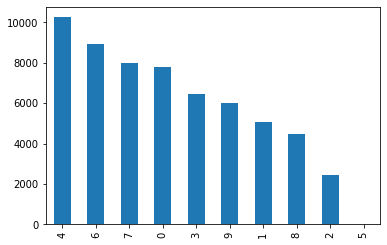

In [281]:
wt['basin_encoded'].value_counts().plot(kind='bar')

In [282]:
## Above we see that one category is negligible. I should go through each variable like this
# removing the bum category to reduce cardinality, but I don't have the time needed to do this task thoroughly
# so consider this an example of what I'd do
# I replace the value with a null, rather than removing the full observation
# If I were to later use a method that can't handle null values, I could remove the observation then
# but most of the good models can handle nulls now and best to save what we can.

wt['basin_encoded'] = wt['basin_encoded'].replace(5, np.nan) # I should do this for every var but for time

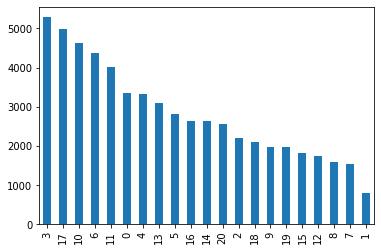

In [283]:
wt['region_encoded'].value_counts().plot(kind='bar')


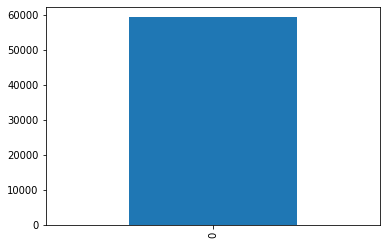

In [284]:
wt['recorded_by_encoded'].value_counts().plot(kind='bar') # dropped later


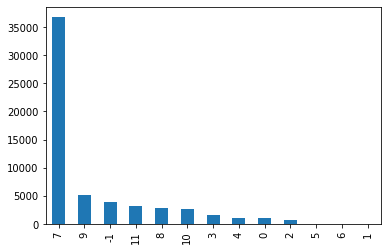

In [285]:
wt['scheme_management_encoded'].value_counts().plot(kind='bar')


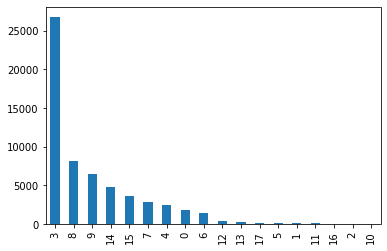

In [286]:
wt['extraction_type_encoded'].value_counts().plot(kind='bar')


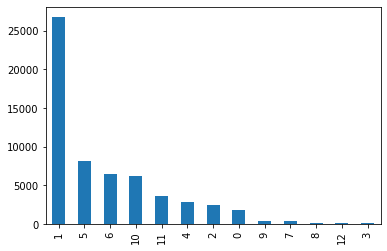

In [287]:
wt['extraction_type_group_encoded'].value_counts().plot(kind='bar')


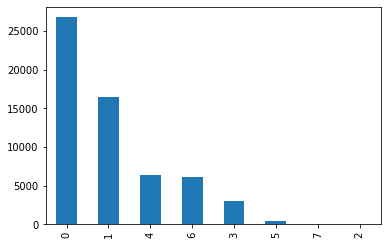

In [288]:
wt['extraction_type_class_encoded'].value_counts().plot(kind='bar')


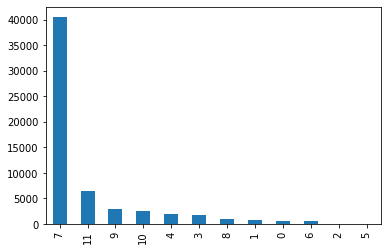

In [289]:
wt['management_encoded'].value_counts().plot(kind='bar')


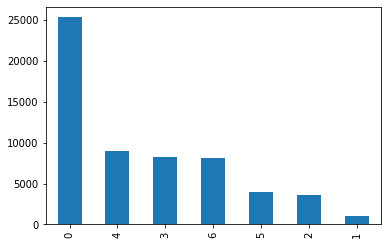

In [290]:
wt['payment_encoded'].value_counts().plot(kind='bar')


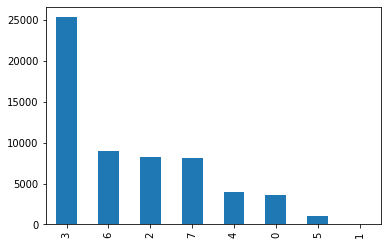

In [291]:
wt['payment_type_encoded'].value_counts().plot(kind='bar')


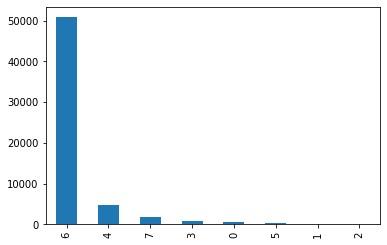

In [292]:
wt['water_quality_encoded'].value_counts().plot(kind='bar')


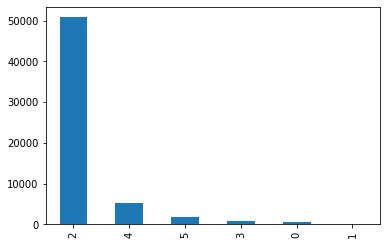

In [293]:
wt['quality_group_encoded'].value_counts().plot(kind='bar')


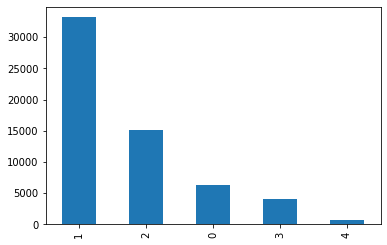

In [294]:
wt['quantity_encoded'].value_counts().plot(kind='bar')


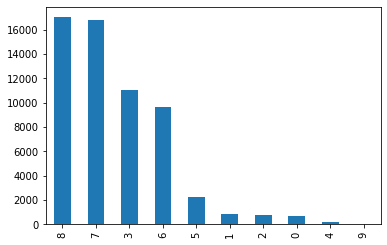

In [295]:
wt['source_encoded'].value_counts().plot(kind='bar')



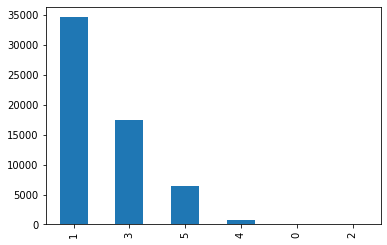

In [296]:
wt['waterpoint_type_group_encoded'].value_counts().plot(kind='bar')


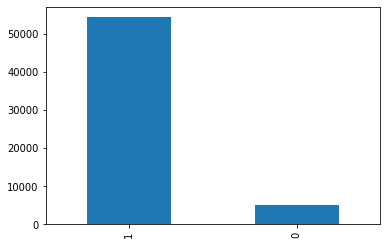

In [297]:
wt['public_meeting_encoded'].value_counts().plot(kind='bar')


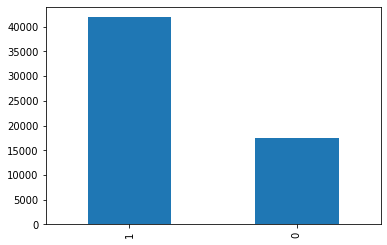

In [298]:
wt['permit_encoded'].value_counts().plot(kind='bar');

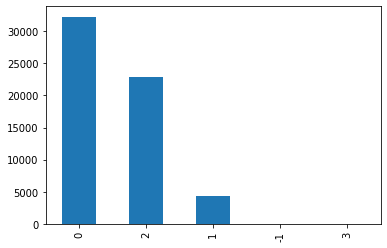

In [299]:
# NB this is the outcome variable - make sure to account for class balance
wt['status_group_encoded'].value_counts().plot(kind='bar') # bum categories dropped later


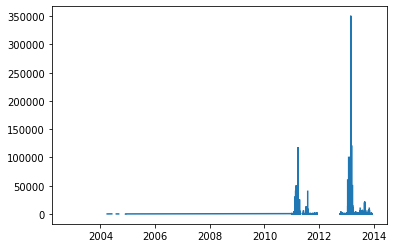

In [300]:
wt = wt.sort_values('date_recorded', ascending=True)
plt.plot(wt['date_recorded'], wt['amount_tsh'])
# plt.xticks(rotation='vertical')

In [21]:
wt['funder'].value_counts() # When I tried to plot this, I regretted choosing pandas over r for this task :D

Government Of Tanzania      9084
Danida                      3115
Hesawa                      2202
Rwssp                       1374
World Bank                  1349
                            ... 
Grail Mission Kiseki Bar       1
Ma                             1
Dmk Anglican                   1
Mkuluku                        1
Subvillage                     1
Name: funder, Length: 1897, dtype: int64

In [27]:
wt['installer'].value_counts()

DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1051
              ...  
EF                1
Dawasco           1
RC Njoro          1
SIPDO             1
brown             1
Name: installer, Length: 2145, dtype: int64

##### With more time I would do something to salvage some of these messy categorical variables e.g installer and funder - I'd make them each a categorical variable where I took the main x funders/installers as their own categories and clumped the  rest into 'else'

In [38]:
## Plotting each var individually should show up these common issues, imagine that I did that plz
# and then heroically removed the bum values
print(0 in wt['installer'])
print('zero' in wt['installer'])
print(''  in wt['installer'])
print(' '  in wt['installer'])
print('unknown'  in wt['installer'])
print('Unknown'  in wt['installer'])

# for numeric variables that should be positive numbers, I should check for negatives

True
False
False
False
False
False


In [334]:
#### Here I'm going to remove outliers (beyond 3 std devs)
# Added after seeing below continuous-variable distributions

# print(wt.shape)
for col in wt[numerics].columns:
    wt[col] = wt[np.abs(wt[col]-wt[col].mean()) <= (3 * wt[col].std())][col]
#     mean = wt[col].mean()
#     wt[col] = wt[col].fillna(mean)
# print(wt.shape)

In [335]:
## remove zeros from numerics, replace with null but leave the observation there.

# NB I notice that num_private doesn't have an explanation in the data dictionary
# I'd google it or follow up on it in a real life setting, but seems like the ethos of this task is to be
# self contained

# After plotting distributions in cells below, I see that many are skewed
# It looks like there are a lot of zeros and it's clear (from e.g construction year) that these zeros
# don't represent actual zeros, but must mean missing data
# This is more ambiguous for e.g latitude and longitude though, where zero is a credible value 
# (I looked it up)

wt['construction_year'] = wt.construction_year.replace(0,np.nan)
wt['amount_tsh'] = wt.amount_tsh.replace(0,np.nan)
wt['population'] = wt.population.replace(0,np.nan)
wt['num_private'] = wt.num_private.replace(0,np.nan)
wt['construction_year'] = wt.construction_year.replace(0.0,np.nan)
wt['amount_tsh'] = wt.amount_tsh.replace(0.0,np.nan)
wt['population'] = wt.population.replace(0.0,np.nan)
wt['num_private'] = wt.num_private.replace(0.0,np.nan)

##### I could instead replace outliers and/or these suspicious zeros with column mean or with KNN imputed value but sticking with null because observations aren't a major limiting factor and because if I went for mean/imputed I'd need to choose it on a case by case basis and time is limited

In [303]:
wt.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_encoded,region_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
count,59402.000000,7874.000000,59400.000000,57590.000000,5.940200e+04,523.000000,37292.000000,38693.000000,59401.000000,59402.000000,...,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000
mean,37115.198209,759.641459,668.263687,35.149721,-5.706111e+00,10.388145,222.991070,1996.813868,4.538358,9.835881,...,1.325747,1.325747,6.063230,4.758325,0.233746,2.574038,2.056177,0.841100,0.914902,0.705515
std,21453.555072,1379.102531,693.059297,2.607422,2.946057e+00,9.553259,258.796663,12.472409,2.896872,5.936992,...,0.803760,0.803760,2.034171,2.575695,0.434134,1.781431,1.378928,0.949874,0.279030,0.455815
min,0.000000,0.200000,-90.000000,29.607122,-1.164944e+01,1.000000,-200.000000,1960.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,18519.250000,50.000000,0.000000,33.285153,-8.540946e+00,4.000000,35.000000,1987.000000,2.000000,4.000000,...,1.000000,1.000000,5.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,37061.500000,250.000000,369.000000,35.005943,-5.021597e+00,6.000000,150.000000,2000.000000,4.000000,10.000000,...,1.000000,1.000000,7.000000,6.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,55657.500000,600.000000,1319.000000,37.233742,-3.326168e+00,15.000000,300.000000,2008.000000,7.000000,15.000000,...,2.000000,2.000000,8.000000,7.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000
max,74247.000000,10000.000000,2628.000000,40.345193,-2.000000e-08,35.000000,1590.000000,2013.000000,9.000000,20.000000,...,4.000000,4.000000,9.000000,7.000000,2.000000,6.000000,5.000000,3.000000,1.000000,1.000000


In [304]:
## Standardise all numerics
# Why standardise? It'll help with detecting multicollinearity but it could make results less interpretable
# It could help later depending on model choice though unlikely. It was a coin flip type of decision
# Some of the distributions are skewed but they're close enough to normal for the sake of standarisation

standardise = lambda x: (x-x.mean()) / x.std()

wt[numerics] = wt[numerics].pipe(standardise)

In [305]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
2603,14428,NaN,2002-10-14,Undp,-0.964223,BESADA,-0.560559,0.667174,Shule,NaN,...,3,3,5,4,1,6,5,0,0,0
27503,53086,NaN,2004-01-07,Kkkt,1.360253,Villagers,-0.095558,-1.075235,Kwa Barnabasi Kilumile,NaN,...,1,1,1,0,0,4,3,0,1,0
33944,5971,NaN,2004-03-01,Amref,-1.003181,AMREF,1.585238,-0.582725,Kwa Ndevu,NaN,...,3,3,7,6,0,4,3,2,1,0
32621,9195,NaN,2004-03-01,Caltus,1.713759,Cultus,-1.384494,-0.772896,Kwa Pambajila,NaN,...,0,0,8,7,0,1,1,2,1,1
23375,20534,NaN,2004-03-01,Tasaf And Lga,-0.619375,TASAFcitizen and LGA,1.581261,-1.803390,Juhudi,NaN,...,1,1,8,7,0,2,1,0,1,0


In [35]:
print(wt.shape)
# wt.dropna(inplace=True)
# print(wt.shape)

(59401, 40)


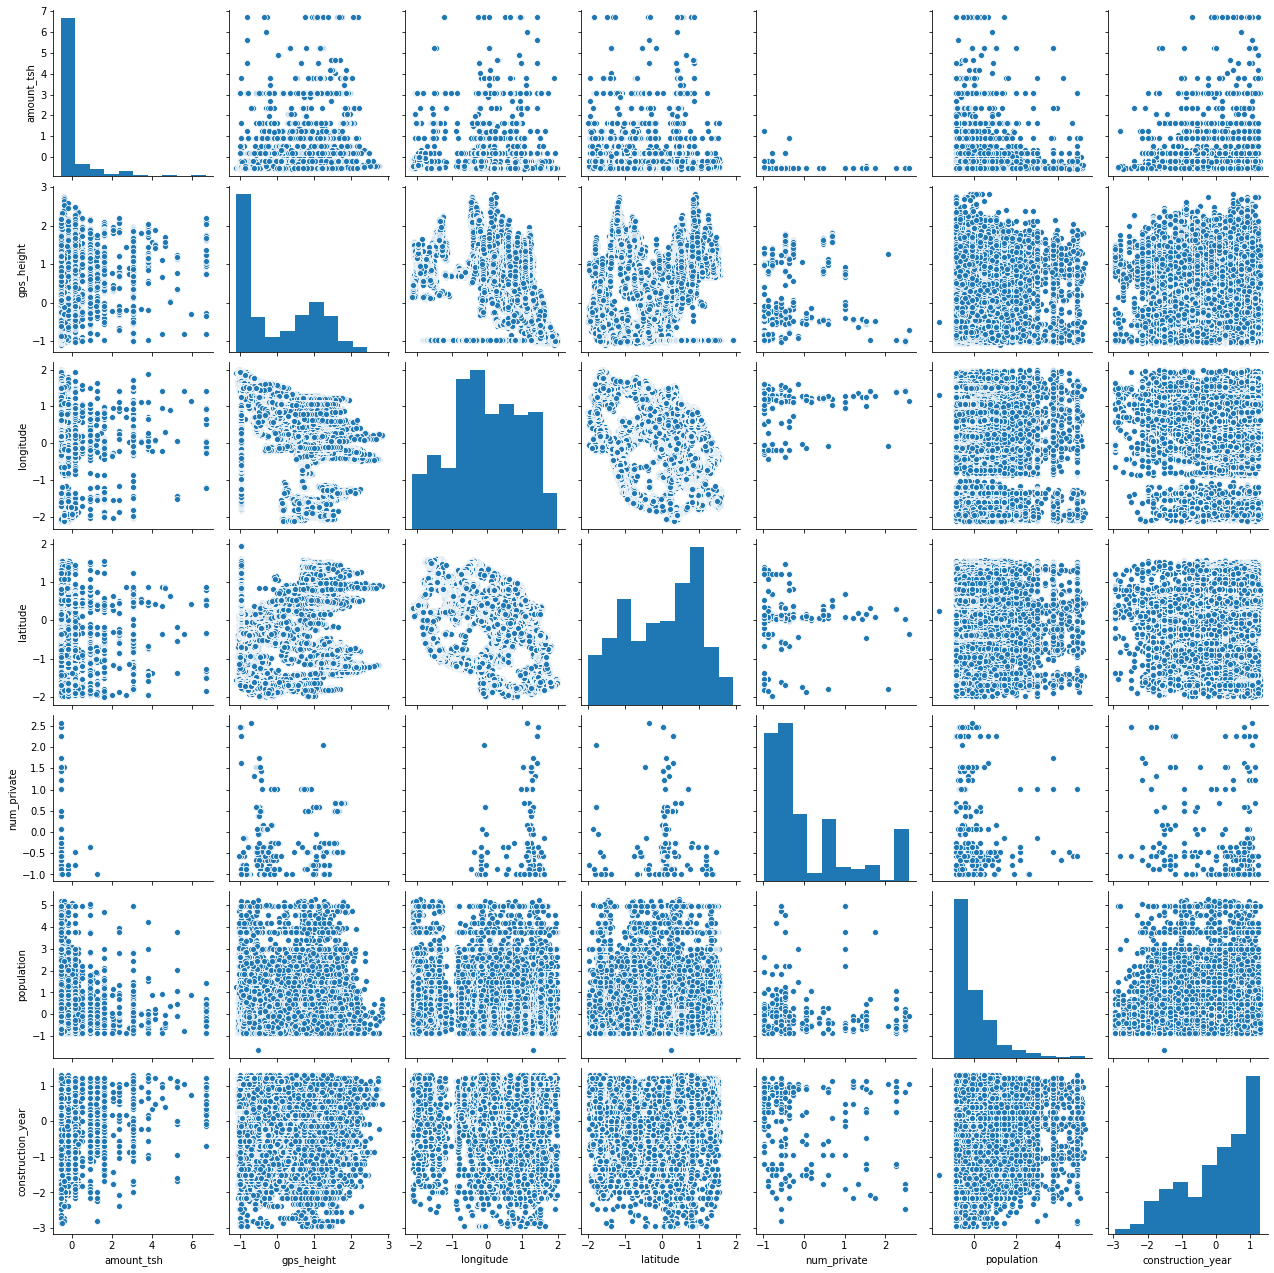

In [307]:
## Continuous vs Continuous

# Pairwise scatterplot --> visually assess distributions and for independence of features

# This and following cells will see if numeric vars show multicolinearity
# If so they could potentially throw off our models, breaking the common assumption of independence
sb.pairplot(wt[numerics])

# Interpretation:
# 1. remove 0's from construction year (why didn't these get caught by cleaning std dev check? -> too many of them
# 2. gps height, lat and long seem to show some relationship
# 3. Lat, Long and Construction yr should pass as normal dist but
# 4. amount_tsh, gps_height, num_private and population look skewed 
# NB I've now removed zeros


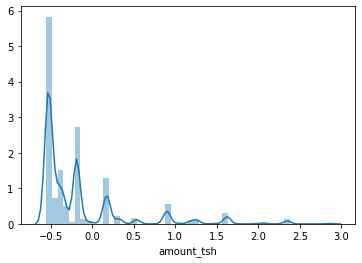

In [336]:
# Distribution of amount_tsh, one of the apparently skewed distributions
sb.distplot(wt.amount_tsh[wt.amount_tsh.apply(lambda x: x < 100)]);

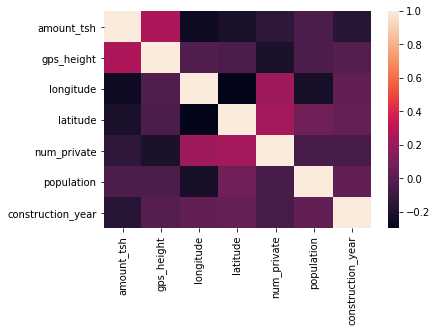

In [337]:
## Pearson heatmap of the continuous variables

sb.heatmap(wt[numerics].corr()) 
# interpretation:
# amount_tsh and gps_height might have a mild correlation
# population and gps_height also
# though remember amount and pop had skewed dist - see next cell

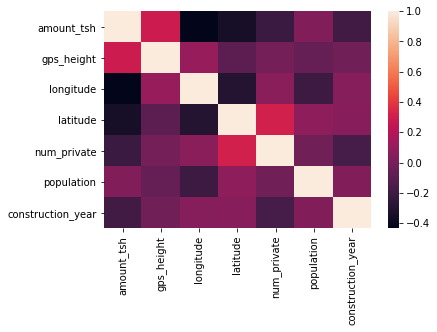

In [338]:
## Spearman heatmap of the continuous variables

sb.heatmap(wt[numerics].corr(method='spearman')) 
# interpretation
# 1. Correlation between amount_tsh and gps_height
# 2. Between latitude and num private

In [339]:
## Matrix of spearman correlation coefficients between continuous variable pairings
wt[numerics].corr(method='spearman')

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
amount_tsh,1.000000,0.287271,-0.434268,-0.348336,-0.214993,0.035895,-0.185027
gps_height,0.287271,1.000000,0.104613,-0.087464,-0.007950,-0.054191,-0.021395
longitude,-0.434268,0.104613,1.000000,-0.299695,0.063931,-0.205966,0.051506
latitude,-0.348336,-0.087464,-0.299695,1.000000,0.314668,0.077413,0.053904
num_private,-0.214993,-0.007950,0.063931,0.314668,1.000000,-0.024503,-0.166187
population,0.035895,-0.054191,-0.205966,0.077413,-0.024503,1.000000,0.033613
construction_year,-0.185027,-0.021395,0.051506,0.053904,-0.166187,0.033613,1.000000


In [340]:
## Temporarily nulls, 
# except for num_private column which is mostly NA

wt_dropna_except_numprivate = wt.dropna(subset=['amount_tsh', 'gps_height', 
                                                                'longitude', 'population', 
                                                                'construction_year'])

# wt_dropna_except_numprivate = wt_dropna_except_numprivate.drop(columns=['num_private'])
wt_dropna_except_numprivate.shape

(6733, 40)

In [341]:
## Get pairwise Distance Covariance 
# Of continuous variable pairings
# NB I made this pip library myself
# Distance correlation is more robust than pearson, ken, spear - Székely, Rizzo and Bakirov (2007) and Lyons (2013)
# not dependent on linear relationship. 0 actually does imply independence
correlade.dcorr(wt_dropna_except_numprivate[numerics])
# Conclusions: 
# gps_height correlates with lat and long


                  amount_tsh gps_height longitude   latitude num_private  \
amount_tsh                 1   0.263889  0.350943   0.234771         NaN   
gps_height          0.263889          1  0.663518    0.38276         NaN   
longitude           0.350943   0.663518         1   0.287266         NaN   
latitude            0.234771    0.38276  0.287266          1         NaN   
num_private              NaN        NaN       NaN        NaN         NaN   
population         0.0556033  0.0866591  0.282059   0.133641         NaN   
construction_year    0.17711  0.0933115  0.134839  0.0731695         NaN   

                  population construction_year  
amount_tsh         0.0556033           0.17711  
gps_height         0.0866591         0.0933115  
longitude           0.282059          0.134839  
latitude            0.133641         0.0731695  
num_private              NaN               NaN  
population                 1         0.0823098  
construction_year  0.0823098                 1  

In [342]:
## Calculate VIF to determine multicolinearity

# code credit - https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
wt_cor = wt[numerics].corr()
pd.Series(np.linalg.inv(wt_cor.values).diagonal(), index=wt_cor.index)

# Conclusion:
# VIF is alright - not too much colinearity despite correlations - will continue without dimensionality reduction

amount_tsh           1.315382
gps_height           1.125339
longitude            1.437244
latitude             1.347183
num_private          1.216074
population           1.062908
construction_year    1.033866
dtype: float64

##### Overall it looks to me like there isn't too much inter-dependence of numeric variables. If there were, I could see if one variable was fully explained by others and so remove it - the fewer variables the better, avoid noise and overfitting (really I should be limiting my choice of features to those that show some trace of relationship to the outcome variable). More likely, I would use dimensionality reduction, PCA or uMAP and pass the principal components with explaining power into the model. This would impede feature extraction though

In [343]:
## Continuous Vs Categorical

# Correlation between a continuous and a categorical --> Point biserial correlation
# Assumptions: normally distributed and homoscedastic --> Appear to be met / close enough
# Output is not pretty - I did a ctrl-f search for status_group_encoded
# Prettiness is for people with a little more time 
for col in wt_dropna_except_numprivate[numerics].drop(columns=['num_private']):
    print('\n \n -------- %s --------- \n' % str(col))
    for y in wt[categorics]:
        print('%s:' % str(y), stats.pointbiserialr(wt_dropna_except_numprivate[col], wt_dropna_except_numprivate[y]))
        
# Interpretation:
# There are sig relationships in the 0.6s range here, between the location-based vars mostly.
# Should ideally delve in a little more, but they're not > 0.7 and time is pressing so onwards
# Construction has a neg correlation with status_group (outcome var) of .19, 
# The other cont vars correlated < .1 with status_group


 
 -------- amount_tsh --------- 

basin_encoded: PointbiserialrResult(correlation=-0.12463797979782137, pvalue=1.0100376935271025e-24)
region_encoded: PointbiserialrResult(correlation=-0.04425480525937153, pvalue=0.0002807678339831466)
recorded_by_encoded: PointbiserialrResult(correlation=nan, pvalue=nan)
scheme_management_encoded: PointbiserialrResult(correlation=0.0034336418405755548, pvalue=0.7781769913399776)
extraction_type_encoded: PointbiserialrResult(correlation=-0.13643773819949645, pvalue=2.4254085915597238e-29)
extraction_type_group_encoded: PointbiserialrResult(correlation=-0.17380510274031086, pvalue=8.170935173016192e-47)
extraction_type_class_encoded: PointbiserialrResult(correlation=-0.2601734027316534, pvalue=1.3389282282410188e-104)
management_encoded: PointbiserialrResult(correlation=-0.017246896172894623, pvalue=0.15705849032068395)
management_group_encoded: PointbiserialrResult(correlation=0.14912571429981186, pvalue=8.719812517616695e-35)
payment_encoded: Pointb

public_meeting_encoded: PointbiserialrResult(correlation=0.037590978454181904, pvalue=0.0020352472443291906)
permit_encoded: PointbiserialrResult(correlation=0.2735186409101235, pvalue=7.878298679912798e-116)

 
 -------- population --------- 

basin_encoded: PointbiserialrResult(correlation=-0.21535089700600749, pvalue=1.7671830239261326e-71)
region_encoded: PointbiserialrResult(correlation=0.030630329342926834, pvalue=0.011954301721207306)
recorded_by_encoded: PointbiserialrResult(correlation=nan, pvalue=nan)
scheme_management_encoded: PointbiserialrResult(correlation=0.022314664557769467, pvalue=0.06711328115500804)
extraction_type_encoded: PointbiserialrResult(correlation=0.0967172831763176, pvalue=1.8160771049919685e-15)
extraction_type_group_encoded: PointbiserialrResult(correlation=0.07305916635523234, pvalue=1.951804375610746e-09)
extraction_type_class_encoded: PointbiserialrResult(correlation=0.050819345935115515, pvalue=3.0207588164310828e-05)
management_encoded: Pointbiseria

/home/ian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 PointbiserialrResult(correlation=-0.01743770648777847, pvalue=0.15251860293074396)
extraction_type_encoded: PointbiserialrResult(correlation=0.08369344157417155, pvalue=6.059302772620114e-12)
extraction_type_group_encoded: PointbiserialrResult(correlation=0.1044887109406053, pvalue=8.272132040392753e-18)
extraction_type_class_encoded: PointbiserialrResult(correlation=0.14910685640831908, pvalue=8.891366094613297e-35)
management_encoded: PointbiserialrResult(correlation=-0.04328543558921977, pvalue=0.0003811744573969732)
management_group_encoded: PointbiserialrResult(correlation=-0.18299822874533106, pvalue=8.670913224666587e-52)
payment_encoded: PointbiserialrResult(correlation=0.15795841144196773, pvalue=7.170583077265577e-39)
payment_type_encoded: PointbiserialrResult(correlation=0.19399312077340836, pvalue=4.277228814448115e-58)
water_quality_encoded: PointbiserialrResult(correlation=-0.05434570824072404, pvalue=8.127451019955436e-06)
quality_group_encoded: PointbiserialrResult(cor

In [344]:
## Categorical vs Categorical

def cramers_V(var1,var2) :
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = stats.chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab) 
  mini = min(crosstab.shape)-1 
  return (stat/(obs*mini))

In [345]:
rows= []

for var1 in wt[categorics]:
  col = []
  for var2 in wt[categorics] :
    cramers = cramers_V(wt[categorics][var1], wt[categorics][var2])
    col.append(round(cramers,2)) 
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = wt[categorics].columns, index = wt[categorics].columns)

df

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


,basin_encoded,region_encoded,recorded_by_encoded,scheme_management_encoded,extraction_type_encoded,extraction_type_group_encoded,extraction_type_class_encoded,management_encoded,management_group_encoded,payment_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
basin_encoded,1.00,0.59,NaN,0.06,0.06,0.06,0.05,0.05,0.02,0.06,...,0.02,0.02,0.06,0.06,0.02,0.04,0.04,0.02,0.01,0.03
region_encoded,0.59,1.00,NaN,0.12,0.07,0.08,0.11,0.12,0.05,0.13,...,0.05,0.05,0.10,0.11,0.05,0.09,0.07,0.04,0.05,0.17
recorded_by_encoded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheme_management_encoded,0.06,0.12,NaN,1.00,0.03,0.03,0.04,0.56,0.48,0.04,...,0.03,0.03,0.05,0.07,0.05,0.04,0.04,0.02,0.04,0.09
extraction_type_encoded,0.06,0.07,NaN,0.03,1.00,1.00,0.86,0.03,0.02,0.06,...,0.02,0.02,0.17,0.20,0.10,0.26,0.29,0.06,0.02,0.04
extraction_type_group_encoded,0.06,0.08,NaN,0.03,1.00,1.00,0.86,0.02,0.01,0.06,...,0.01,0.01,0.15,0.19,0.07,0.25,0.29,0.06,0.01,0.04
extraction_type_class_encoded,0.05,0.11,NaN,0.04,0.86,0.86,1.00,0.03,0.01,0.05,...,0.01,0.01,0.18,0.17,0.07,0.25,0.29,0.06,0.01,0.03
management_encoded,0.05,0.12,NaN,0.56,0.03,0.02,0.03,1.00,1.00,0.05,...,0.06,0.06,0.05,0.06,0.04,0.02,0.03,0.02,0.06,0.06
management_group_encoded,0.02,0.05,NaN,0.48,0.02,0.01,0.01,1.00,1.00,0.02,...,0.05,0.05,0.05,0.05,0.02,0.00,0.00,0.00,0.05,0.00
payment_encoded,0.06,0.13,NaN,0.04,0.06,0.06,0.05,0.05,0.02,1.00,...,0.02,0.02,0.04,0.04,0.01,0.03,0.03,0.03,0.02,0.03


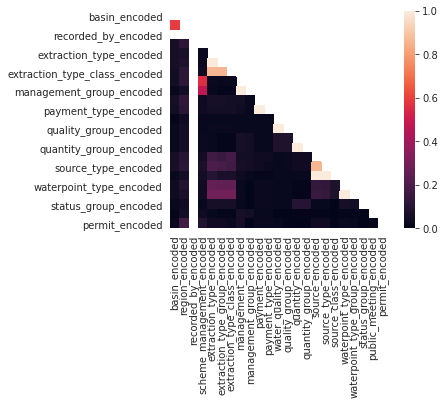

In [346]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sb.axes_style("white"):
  ax = sb.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

Interpreation of categorical vs categorical:

Again some correlations between mostly geographic vars

Additionally can remove source_type_encoded, source_class_encoded, extraction_type_group_encoded and management_group_encoded as these are clearly redundant

Nothing here correlates strongly with status_group_encoded, the outcome var

In [347]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,subvillage,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
2603,14428,NaN,2002-10-14,Undp,-0.964223,BESADA,-0.560559,0.667174,NaN,Mwawe Ja,...,3,3,5,4,1,6,5,0,0,0
27503,53086,NaN,2004-01-07,Kkkt,1.360253,Villagers,-0.095558,-1.075235,NaN,Mlowa,...,1,1,1,0,0,4,3,0,1,0
33944,5971,NaN,2004-03-01,Amref,-1.003181,AMREF,1.585238,-0.582725,NaN,Gundani,...,3,3,7,6,0,4,3,2,1,0
32621,9195,NaN,2004-03-01,Caltus,1.713759,Cultus,-1.384494,-0.772896,NaN,Magomeni,...,0,0,8,7,0,1,1,2,1,1
23375,20534,NaN,2004-03-01,Tasaf And Lga,-0.619375,TASAFcitizen and LGA,1.581261,-1.803390,NaN,Mwanona,...,1,1,8,7,0,2,1,0,1,0


In [348]:
wt.recorded_by_encoded.value_counts() # Empty var

0    59399
Name: recorded_by_encoded, dtype: int64

In [349]:
remove_cols =['source_type_encoded', 'source_class_encoded', 'extraction_type_group_encoded', 
                 'management_group_encoded']

In [350]:
export_cols = numerics + categorics
export_cols = [ x for x in export_cols if x not in remove_cols]

In [351]:
export_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'construction_year',
 'basin_encoded',
 'region_encoded',
 'recorded_by_encoded',
 'scheme_management_encoded',
 'extraction_type_encoded',
 'extraction_type_class_encoded',
 'management_encoded',
 'payment_encoded',
 'payment_type_encoded',
 'water_quality_encoded',
 'quality_group_encoded',
 'quantity_encoded',
 'quantity_group_encoded',
 'source_encoded',
 'waterpoint_type_encoded',
 'waterpoint_type_group_encoded',
 'status_group_encoded',
 'public_meeting_encoded',
 'permit_encoded']

In [352]:
wt.shape

(59399, 40)

In [353]:
wt.dropna().shape # not going to drop NAs ;)

(91, 40)

In [37]:
# Remove original version of categorical vars that have been encoded
# wt = wt.drop(columns=[x.replace('_encoded', '') for x in wt.columns if '_encoded' in x])

In [ ]:
# wt = wt.drop(columns=['wpt_name']) # drop this col, too far from categorical to be useful

In [ ]:
## Check for typos or erroneous data in outcome var
wt.status_group_encoded.value_counts()

In [ ]:
# Remove any line without a valid outcome var
wt['status_group_encoded'] = wt.status_group_encoded.replace(-1, np.nan)
wt['status_group_encoded'] = wt.status_group_encoded.replace(3, np.nan)
wt = wt.dropna(subset=['status_group_encoded'])
wt['status_group_encoded'] = wt['status_group_encoded'].astype(int)

In [ ]:
## Export to be used in ML notebook
wt[export_cols].to_csv("wt_for_ml.csv", index=False)